# LinearModelV0 with FewShotDataset

This notebook is an experimental approach on solving the ARC challenge. See https://arcprize.org/ for more details.

In [1]:
import os
import random

import torch

from pathlib import Path

from arc2024.data import FewShotDataset
from arc2024.utils import plot
from arc2024.utils.calc import accuracy_fn, norm_arc20204
from arc2024.models.non_linear import NonLinearModelV0

# Setup Device Agnostic Environment

In [2]:
import arc2024.utils.amdgpu as amd

if amd.is_amdgpu_on_linux():
    # Use ROCm on rx6600/6600xt by setting the environment variable HSA_OVERRIDE_GFX_VERSION to "10.3.0"
    # Source: https://github.com/ROCm/ROCm/issues/1698#issuecomment-1261646854
    amd.setup_amdgpu_environment(
        hsa_override_gfx_version="10.3.0"
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Prepare Datasets and DataLoaders

In [3]:
dataset_dir = Path('datasets')

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataset = FewShotDataset(
    dataset_dir=dataset_dir,
    dataset_name='training',
    permutations_enabled=True
)
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataset = FewShotDataset(
    dataset_dir=dataset_dir,
    dataset_name='evaluation'
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

## Train Model

In [5]:
model = NonLinearModelV0(
    in_features=900, # 30x30
    hidden_features=600, # do some compression
    out_features=900
).to(device)

model

NonLinearModelV0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=900, out_features=600, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=600, out_features=900, bias=True)
  (relu2): ReLU()
  (unflatten): Unflatten(dim=1, unflattened_size=(1, 30, 30))
)

### Verify Input and Output Shapes with Random Tensor

In [5]:
x = torch.rand([1, 30, 30]).to(device)
model(x).shape

torch.Size([1, 1, 30, 30])

In [6]:
X, y, _ = train_dataset[0]
X = X.to(device) / 10
y = y.to(device) / 10

y_pred = model(X)
y_pred, y_pred.shape

(tensor([[[[0.1616, 0.5808, 0.0000, 0.1905, 0.0000, 0.0882, 0.1266, 0.1101,
            0.0562, 0.0000, 0.0000, 0.0000, 0.0000, 0.2197, 0.3875, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0461, 0.0000, 0.0928, 0.0000,
            0.0130, 0.0000, 0.3987, 0.0000, 0.1360, 0.5793],
           [0.1371, 0.0393, 0.0000, 0.0151, 0.0000, 0.0000, 0.5231, 0.1874,
            0.0000, 0.0000, 0.0569, 0.1457, 0.0000, 0.0000, 0.0000, 0.1606,
            0.0507, 0.0000, 0.4667, 0.1733, 0.1434, 0.0156, 0.2047, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6841],
           [0.1206, 0.4218, 0.0000, 0.2076, 0.0000, 0.0770, 0.0000, 0.3432,
            0.0000, 0.0000, 0.1939, 0.0000, 0.4347, 0.0197, 0.0000, 0.7384,
            0.0000, 0.1315, 0.2661, 0.0030, 0.0110, 0.1159, 0.1432, 0.0768,
            0.1300, 0.2811, 0.0000, 0.2150, 0.0000, 0.0000],
           [0.0891, 0.0969, 0.0000, 0.0000, 0.0000, 0.1536, 0.4914, 0.0662,
            0.0445, 0.0000, 0.0000, 0.0000, 0.1206, 0.206

### Setup Loss, optimizer and evaluation metrics

In [7]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

### Run Training Loop

In [8]:
from timeit import default_timer as timer 

epochs = 50

time_start = timer()
for epoch in range(epochs):
    ### Training
    train_loss = 0
    train_accuracy = 0

    model.train() # Set model into training mode
    
    for b, (X_train, y_train, challenge_ids) in enumerate(train_dataloader):
        for challenge_id in challenge_ids:
            X_shots, y_shots = train_dataset.get_samples(challenge_id)
            X_shots, y_shots = X_shots.to(device) / 10, y_shots.to(device) / 10
            
            # Forward pass:
            shots_pred = model(X_shots)
            
            # Calculate loss:
            loss = loss_fn(shots_pred, y_shots)
            
            # Reset optimizer gradients:
            optimizer.zero_grad()
            
            # Backward pass:
            loss.backward()
            
            # Adjust parameters:
            optimizer.step()
        
        # Send to device and normalize:
        X_train, y_train = X_train.to(device) / 10, y_train.to(device) / 10
        
        # Forward pass:
        train_pred = model(X_train)
        
        # Calculate loss:
        loss = loss_fn(train_pred, y_train)
        train_loss += loss
        train_accuracy += accuracy_fn(y_train, norm_arc20204(train_pred))
        
        # Reset optimizer gradients:
        optimizer.zero_grad()
        
        # Backward pass:
        loss.backward()
        
        # Adjust parameters:
        optimizer.step()

    train_loss /= len(train_dataloader.dataset)
    train_accuracy /= len(train_dataloader.dataset)
    
    ### Testing
    test_loss = 0
    test_accuracy = 0
    model.eval() # set model into evaluation mode

    with torch.inference_mode():
        for X_test, y_test, _ in test_dataloader:
            # Send to device and normalize:
            X_test, y_test = X_test.to(device) / 10, y_test.to(device) / 10

            # Forward pass:
            test_pred = model(X_test)

            # Calculate loss:
            loss = loss_fn(test_pred, y_test)
            test_loss += loss
            test_accuracy += accuracy_fn(y_test, norm_arc20204(test_pred))
    
        test_loss /= len(test_dataloader.dataset)
        test_accuracy /= len(test_dataloader.dataset)
    
    print(f"Epoch {epoch + 1}/{epochs} | Train loss: {train_loss:.5f} | Train accuracy: {train_accuracy:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.2f}%")
time_end = timer()

print(f"Total time taken: {time_end - time_start}")

Epoch 1/50 | Train loss: 0.01075 | Train accuracy: 0.09% | Test loss: 0.01042 | Test accuracy: 0.23%
Epoch 2/50 | Train loss: 0.00984 | Train accuracy: 0.07% | Test loss: 0.01018 | Test accuracy: 0.19%
Epoch 3/50 | Train loss: 0.00954 | Train accuracy: 0.06% | Test loss: 0.00977 | Test accuracy: 0.20%
Epoch 4/50 | Train loss: 0.00924 | Train accuracy: 0.06% | Test loss: 0.00945 | Test accuracy: 0.21%
Epoch 5/50 | Train loss: 0.00907 | Train accuracy: 0.06% | Test loss: 0.00947 | Test accuracy: 0.19%
Epoch 6/50 | Train loss: 0.00891 | Train accuracy: 0.06% | Test loss: 0.00924 | Test accuracy: 0.20%
Epoch 7/50 | Train loss: 0.00867 | Train accuracy: 0.06% | Test loss: 0.00900 | Test accuracy: 0.19%
Epoch 8/50 | Train loss: 0.00849 | Train accuracy: 0.07% | Test loss: 0.00888 | Test accuracy: 0.19%
Epoch 9/50 | Train loss: 0.00827 | Train accuracy: 0.07% | Test loss: 0.00868 | Test accuracy: 0.20%
Epoch 10/50 | Train loss: 0.00818 | Train accuracy: 0.07% | Test loss: 0.00872 | Test accur

# Evaluate Model

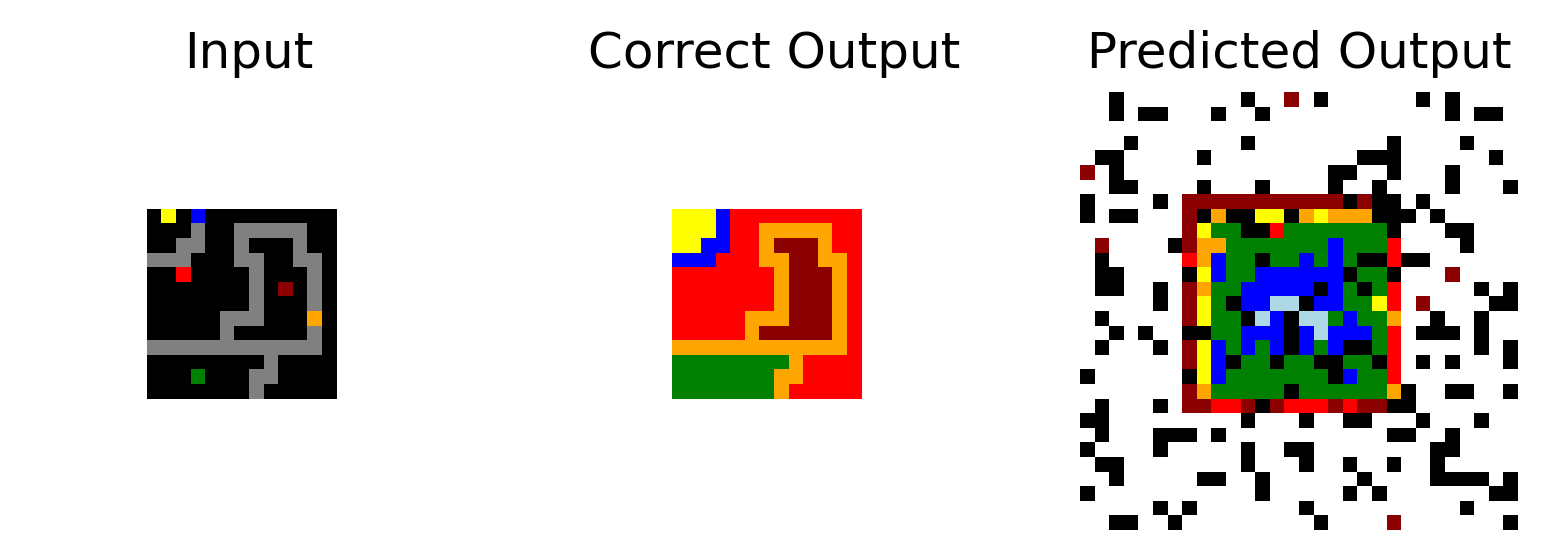

Accuracy: 11.33% (102/900)


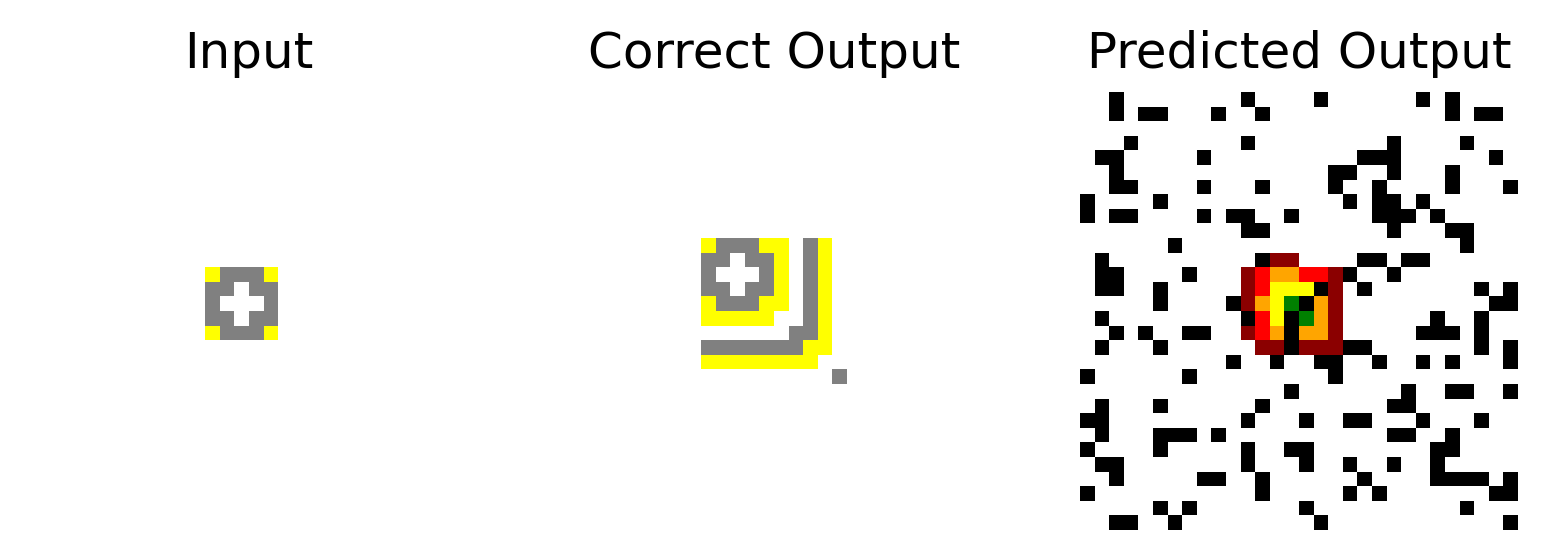

Accuracy: 44.11% (397/900)


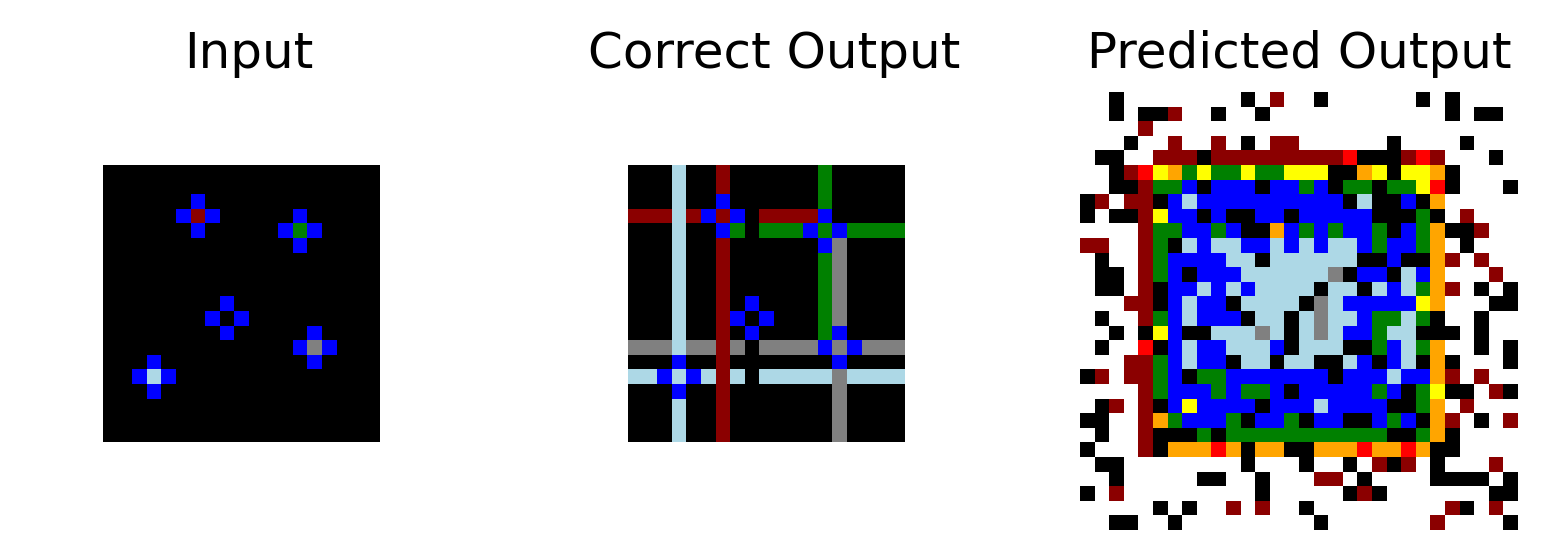

Accuracy: 10.00% (90/900)


In [13]:
evaluations = 3

evaluation_dataset = FewShotDataset(
    dataset_dir=dataset_dir,
    dataset_name='evaluation'
)

model.eval() # set model into evaluation mode
with torch.inference_mode():
    
    for _ in range(evaluations):
        X, y, _ = random.choice(evaluation_dataset)
        X, y = X.to(device) / 10, y.to(device) / 10
        
        y_pred = model(X)[0]
        y_pred_norm = norm_arc20204(y_pred)
        
        plot.input_and_output(X * 10, y * 10, y_pred_norm * 10)
        accuracy_pred = accuracy_fn(y, y_pred_norm)
        print(f"Accuracy: {accuracy_pred:.2f}% ({int(accuracy_pred / 100 * 900)}/900)")
